<a href="https://colab.research.google.com/github/suhaodatascichem/Soybean-Meal-price/blob/main/Soybean%20meal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import required libraries

In [ ]:
# required libraries
import pandas as pd
import numpy as np
import datetime as dt

# for plots
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import math, time
from sklearn.metrics import mean_squared_error
import time
from sklearn.metrics import mean_squared_error

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Read Data

In [ ]:
filename = '/content/daily_forecast.csv'
df = pd.read_csv(filename)

In [ ]:
df.head()

,DateKey,DailySalesQuantity,DailySalesAmount,DailyCost,DailyProfit,avg_inflation,Promo
0,2007-01-01,66,6410.0715,3432.0,2978.0715,4.105520,1
1,2007-01-02,42,4008.2070,2184.0,1824.2070,5.375422,1
2,2007-01-03,66,6410.0715,3432.0,2978.0715,5.375120,1
3,2007-01-04,60,5813.4300,3120.0,2693.4300,3.850579,1
4,2007-01-05,48,4620.1470,2496.0,2124.1470,4.910569,1


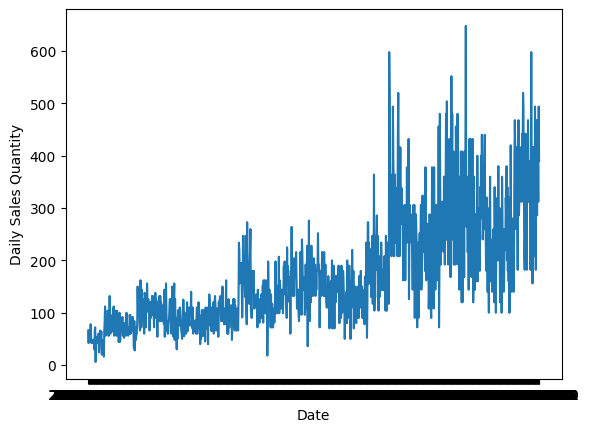

In [ ]:
plt.plot(df["DateKey"], df["DailySalesQuantity"])
plt.xlabel("Date")
plt.ylabel("Daily Sales Quantity")
plt.figsize=(16,6)
plt.show()

# Data Prep

In [ ]:
#Function to perform the train test split on the df based on the desired window_size (ws)
def train_test_prep(series, x_variables, y_variables,  window_size, test_size):
  # series should be a numpy series
  x_series = series[x_variables].to_numpy()
  y_series = series[y_variables].to_numpy()

  x_data = []
  y_data = []
  for i in range(len(x_series) - window_size):
    x_data.append(x_series[i: i+window_size])
    y_data.append(y_series[i+window_size])
  x_data = np.array(x_data)
  y_data = np.array(y_data)

  train_size = x_data.shape[0] - test_size

  train_x = x_data[:train_size, :,:]
  train_y = y_data[:train_size, :]

  test_x = x_data[train_size:train_size+test_size, :,:]
  test_y = y_data[train_size:train_size+test_size:, :]

  return [train_x, train_y, test_x, test_y]

In [ ]:
ws = 30
test_size = 180

In [ ]:
x_train, y_train, x_test, y_test = train_test_prep(df, ["DailySalesQuantity"], ["DailySalesQuantity"], ws,test_size)

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((886, 30, 1), (180, 30, 1), (886, 1), (180, 1))

In [ ]:
#Function to obtain train, test data as tensors for torch
def array_to_tensor(x_train, x_test, y_train, y_test):
  x_train_torch = torch.from_numpy(x_train).type(torch.Tensor).cuda()
  x_test_torch = torch.from_numpy(x_test).type(torch.Tensor).cuda()
  y_train_torch = torch.from_numpy(y_train).type(torch.Tensor).cuda()
  y_test_torch = torch.from_numpy(y_test).type(torch.Tensor).cuda()
  return x_train_torch, x_test_torch, y_train_torch, y_test_torch

In [ ]:
x_train_torch, x_test_torch, y_train_torch, y_test_torch = array_to_tensor(x_train, x_test, y_train, y_test)

In [ ]:
x_train_torch.shape, x_test_torch.shape, y_train_torch.shape, y_test_torch.shape

(torch.Size([886, 30, 1]),
 torch.Size([180, 30, 1]),
 torch.Size([886, 1]),
 torch.Size([180, 1]))

# Baseline model

In [ ]:
# base line model that uses the previous time stamp's demand as the predicted demand

#function for baseline model
def baseline_rmse(df_lstm, ws, y_train_data, column_name):
  y_base_test = np.array(df[column_name][ws+y_train.shape[0]-1:-1],dtype=np.float32)
  y_base_label = np.array(df[column_name][ws+y_train.shape[0]:],dtype=np.float32)

  print(y_base_test, y_base_label)
  rmse_loss_test = np.sqrt(mean_squared_error(y_base_test, y_base_label))
  return rmse_loss_test

In [ ]:
baseline_rmse(df_lstm, ws, y_train, 'DailySalesQuantity')

[360. 408. 648. 336. 264. 360. 216. 216. 240. 144. 312. 432. 240. 216.
 432. 240. 168. 384. 408. 432. 120. 240. 360. 216. 144. 288. 288. 216.
 280. 160. 400. 160. 300. 260. 220. 260. 180. 340. 280. 400. 340. 440.
 360. 240. 260. 360. 260. 380. 440. 300. 280. 200. 180. 320. 260. 140.
 260. 180. 100. 300. 280. 360. 160. 240. 160. 200. 140. 160. 220. 260.
 240. 120. 340. 200. 180. 100. 240. 200. 200. 320. 220. 380. 200. 200.
 300. 120. 220. 180. 260. 100. 360. 280. 160. 260. 140. 160. 240. 260.
 220. 320. 280. 380. 200. 340. 180. 220. 160. 320. 100. 300. 160. 420.
 240. 140. 240. 220. 280. 200. 140. 180. 390. 468. 416. 260. 390. 416.
 416. 260. 182. 338. 468. 286. 312. 390. 338. 416. 416. 312. 312. 442.
 416. 520. 494. 338. 208. 182. 260. 442. 234. 286. 182. 364. 338. 468.
 312. 312. 338. 390. 364. 182. 416. 598. 364. 338. 156. 416. 312. 416.
 312. 208. 494. 390. 182. 416. 468. 286. 416. 416. 312. 494.] [408. 648. 336. 264. 360. 216. 216. 240. 144. 312. 432. 240. 216. 432.
 240. 168. 384.

127.901436

# LSTM Model Architecture


In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().cuda()
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
def build_lstm_model(input_dim, hidden_dim, num_layers, output_dim, num_epochs):
  model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
  model = model.cuda()
  cr = torch.nn.MSELoss(reduction='mean')
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  return model, cr, optimizer

In [ ]:
#General Parameters
input_dim = 1
output_dim = 1


# Train LSTM Model

In [ ]:
def train_model(model, cr, optimizer, x_train_torch, y_train_torch, x_test_torch, y_test_torch, num_epochs):
  torch.manual_seed(42)
  torch.cuda.manual_seed(42)
  torch.cuda.manual_seed_all(42)
  np.random.seed(42)
  torch.backends.cudnn.deterministic = True

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)
  start_time = time.time()
  lstm = []


  for t in range(num_epochs):
    model.train()
    y_train_pred = model(x_train_torch)
    loss = cr(y_train_pred, y_train_torch)
    train_hist[t] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
      y_test_pred = model(x_test_torch)
      loss = cr(y_test_pred, y_test_torch)
      test_hist[t] = loss.item()
      #print("Epoch ", t, "train MSE: ", train_hist[t], "Test MSE:", test_hist[t])

  training_time = time.time()-start_time
  #print("Training time: {}".format(training_time))
  return y_train_pred, y_test_pred

# Get Train Test RMSE



In [ ]:
def get_test_rmse(x_test_torch, y_test_torch, model, ws, test_size):
  x_test_array = x_test_torch[:1]
  y_test_array = []
  for i in range(test_size):
    y_pred = model(x_test_array).cpu().detach().numpy()
    x_test_array = x_test_array.cpu().detach().numpy()
    y_test_array = np.append(y_test_array, y_pred)
    x_test_array = np.append(x_test_array, y_pred)
    # print( x_test_array[-ws:],  x_test_array[-3:].shape)
    x_test_array = x_test_array[-ws:].reshape(1,ws,1)
    x_test_array = torch.from_numpy(x_test_array).type(torch.Tensor).cuda()
  print(x_test_)
  print(y_test_array, y_test_array.shape)
  y_test_array = y_test_array.reshape(ws,1)
  y_test_final = y_test_torch.cpu().detach().numpy()
  testScore = math.sqrt(mean_squared_error(y_test_final[:,0], y_test_array[:,0]))
  print("Test RMSE: ",testScore)
  return testScore

In [ ]:
def get_train_RMSE(y_train_pred, y_train_torch ):
  # invert predictions
  y_train_pred = y_train_pred.cpu().detach().numpy()
  y_train_final = y_train_torch.cpu().detach().numpy()

  # calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(y_train_final[:,0], y_train_pred[:,0]))
  print(f"Train RMSE: ",trainScore)

  return trainScore

In [ ]:
def get_RMSE(y_train_pred, y_train_torch , type='Train'):
  # invert predictions
  y_train_pred = y_train_pred.cpu().detach().numpy()
  y_train_final = y_train_torch.cpu().detach().numpy()

  # calculate root mean squared error
  trainScore = math.sqrt(mean_squared_error(y_train_final[:,0], y_train_pred[:,0]))
  print(f"{type} RMSE: ",trainScore)

  return trainScore

#Model parameters fine tuneing

In [ ]:
# Function to vary the number of layers and hidden dimensions, and epochs to find the combination with the best RMSE

def model_tuning(x_train_torch, y_train_torch, x_test_torch, y_test_torch, input_dim, output_dim):
  torch.manual_seed(42)
  torch.cuda.manual_seed(42)
  torch.cuda.manual_seed_all(42)
  np.random.seed(42)
  torch.backends.cudnn.deterministic = True
  testscore = 0
  nl = 0
  hd = 0
  epochs = 0
  summary = []
  for num_epochs in [100, 200, 300, 400]:
    for num_layers in [2, 3, 4, 5]:
      for hidden_dim in [25, 50, 75, 100]:
        model, cr, optimizer = build_lstm_model(input_dim, hidden_dim, num_layers, output_dim, num_epochs)
        y_train_pred, y_test_pred = train_model(model, cr, optimizer, x_train_torch, y_train_torch, x_test_torch, y_test_torch, num_epochs)
        train_score = get_RMSE(y_train_torch, y_train_pred, type='Train')
        # test_score = get_test_rmse(x_test_torch, y_test_torch, model, ws, test_size)
        test_score = get_RMSE(y_test_torch, y_test_pred, type='Test')
        print(", Number of layers: ", num_layers, ", Hidden dimensions: ", hidden_dim, ", Number of Epochs:", num_epochs)
        summary.append({
            'Number of layers': num_layers,
            'Hidden dimensions': hidden_dim,
            'Number of Epochs': num_epochs,
            'Train RMSE': train_score,
            'Test RMSE': test_score
        })

        if test_score < testscore or testscore == 0 :
          testscore = test_score
          nl = num_layers
          hd = hidden_dim
          epochs = num_epochs
  print("Optimum Number of layers:", nl, "Optimum Hidden dimensions:", hd, "Optimum Number of Epochs:",epochs,"Test RMSE:", testscore)
  return nl, hd, epochs, summary

In [ ]:
nl, hd, epochs, summary = model_tuning(x_train_torch, y_train_torch, x_test_torch, y_test_torch, input_dim, output_dim)

Train RMSE:  153.478565024159
Test RMSE:  282.6918181739613
, Number of layers:  2 , Hidden dimensions:  25 , Number of Epochs: 100
Train RMSE:  134.75126100986958
Test RMSE:  260.4947066400774
, Number of layers:  2 , Hidden dimensions:  50 , Number of Epochs: 100
Train RMSE:  119.34422459973713
Test RMSE:  240.65308277684704
, Number of layers:  2 , Hidden dimensions:  75 , Number of Epochs: 100
Train RMSE:  110.51274318489249
Test RMSE:  228.04072073316203
, Number of layers:  2 , Hidden dimensions:  100 , Number of Epochs: 100
Train RMSE:  153.93897811917228
Test RMSE:  283.22699597672533
, Number of layers:  3 , Hidden dimensions:  25 , Number of Epochs: 100
Train RMSE:  136.62132600275112
Test RMSE:  262.78016299275714
, Number of layers:  3 , Hidden dimensions:  50 , Number of Epochs: 100
Train RMSE:  121.82334642577752
Test RMSE:  243.99172309219836
, Number of layers:  3 , Hidden dimensions:  75 , Number of Epochs: 100
Train RMSE:  112.04273825336696
Test RMSE:  230.3243806297

In [ ]:
summary_df = pd.DataFrame(summary)
summary_df

,Number of layers,Hidden dimensions,Number of Epochs,Train RMSE,Test RMSE
0,2,25,100,153.478565,282.691818
1,2,50,100,134.751261,260.494707
2,2,75,100,119.344225,240.653083
3,2,100,100,110.512743,228.040721
4,3,25,100,153.938978,283.226996
...,...,...,...,...,...
59,4,100,400,89.323857,173.880779
60,5,25,400,108.580399,225.520907
61,5,50,400,91.192903,188.364486
62,5,75,400,89.376199,175.998818


In [ ]:
summary_df.to_csv('summary.csv')

In [ ]:
input_dim = 1
hidden_dim = 100
num_layers = 5
output_dim = 1
num_epochs = 400
model, cr, optimizer = build_lstm_model(input_dim, hidden_dim, num_layers, output_dim, num_epochs)
y_train_pred, y_test_pred = train_model(model, cr, optimizer, x_train_torch, y_train_torch, x_test_torch, y_test_torch, num_epochs)

In [ ]:
y_train.shape, y_train_pred.shape

((886, 1), torch.Size([886, 1]))

In [ ]:
print(type(y_train))

<class 'numpy.ndarray'>


In [ ]:
predict_train = pd.DataFrame(y_train_pred.cpu().detach().numpy())
original_train = pd.DataFrame(y_train)
predict_test = pd.DataFrame(y_test_pred.cpu().detach().numpy())
original_test = pd.DataFrame(y_test)


In [ ]:
predict_train.shape, predict_test.shape

((886, 1), (180, 1))

In [ ]:
predict_test.head()

,0
0,151.34404
1,151.34404
2,151.34404
3,151.34404
4,151.34404


ValueError: array length 180 does not match index length 210

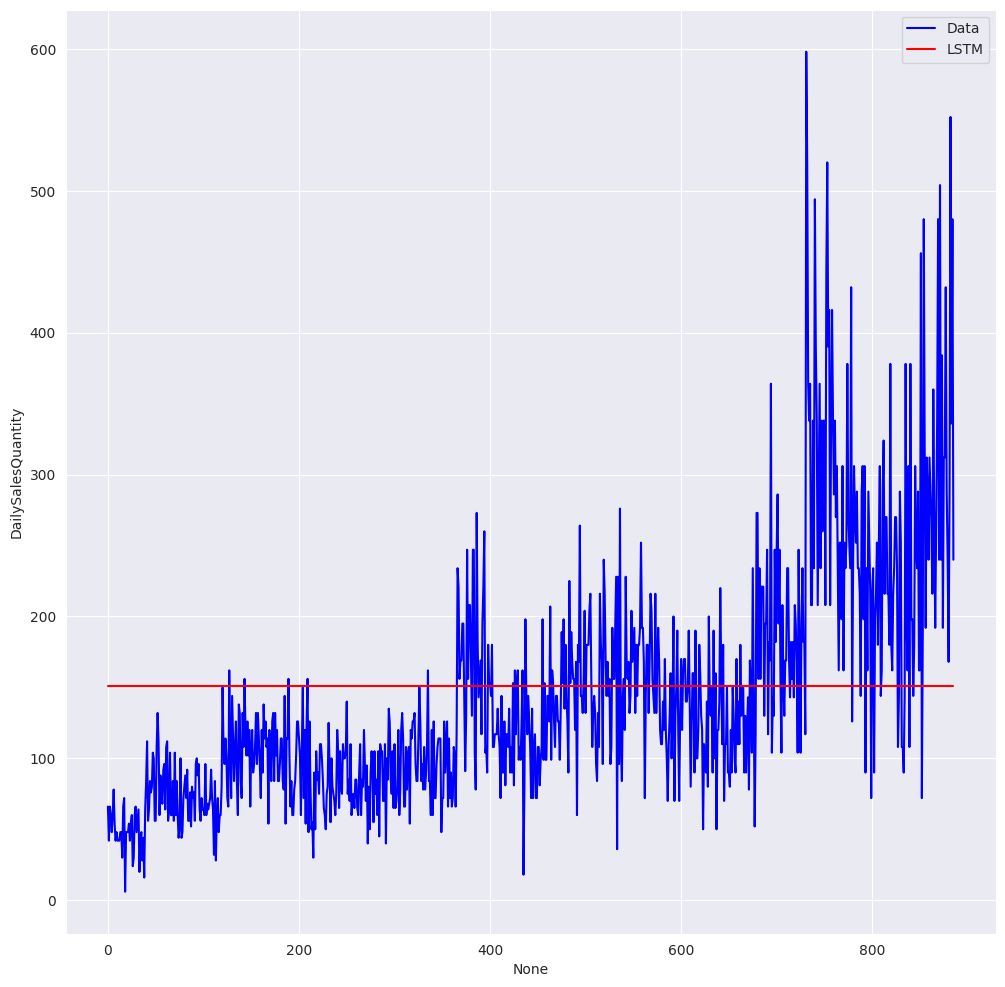

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")

fig = plt.figure(figsize=(12,12))
fig.subplots_adjust(hspace=0.2, wspace=0.2)


ax = sns.lineplot(x = original_train.index, y = df['DailySalesQuantity'][:886], label="Data", color='blue')
ax = sns.lineplot(x = predict_train.index, y = predict[0], label="LSTM", color='red')
ax = sns.lineplot(x = original_test.index, y = df['DailySalesQuantity'][886:], label="Data", color='yellow')
ax = sns.lineplot(x = predict_test.index, y = predict[0], label="LSTM", color='green')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


#plt.subplot(1, 2, 2)
#ax = sns.lineplot(data=hist, color='royalblue')
#ax.set_xlabel("Epoch", size = 14)
#ax.set_ylabel("Loss", size = 14)
#ax.set_title("Training Loss", size = 14, fontweight='bold')
#fig.set_figheight(6)
#fig.set_figwidth(16)

## Create model


In [ ]:
def get_best_model(input_dim, hidden_dim, num_layers, output_dim, x_train_torch, y_train_torch, x_test_torch, y_test_torch, num_epochs, ws, test_size):
  model, cr, optimizer = build_lstm_model(input_dim, hidden_dim, num_layers, output_dim, num_epochs)
  y_train_pred, y_test_pred = train_model(model, cr, optimizer, x_train_torch, y_train_torch, x_test_torch, y_test_torch, num_epochs)
  train_score = get_train_RMSE(y_train_pred, y_train_torch)
  test_score = get_test_rmse(x_test_torch, y_test_torch, model, ws, test_size)
  return train_score, test_score, model

#Get x months ahead worth of predictions

In [ ]:
#Function to take in the correct window of data and generate 5 months ahead predictions
def forecast_x_months(ws, df, model, months_ahead, column_name):
  predictions = []
  current_window = df[[column_name]][-ws:].to_numpy()
  current_window = current_window.reshape(1,ws,1)
  for i in range(months_ahead):
    current_window_torch = torch.from_numpy(current_window).type(torch.Tensor).cuda()
    pred = model(current_window_torch)
    pred = pred.cpu().detach().numpy()
    predictions.append(pred)
    current_window_torch = current_window_torch.cpu().detach().numpy()
    current_window = np.append(current_window, pred)
    current_window = current_window[-ws:].reshape(1,ws,1)
  predictions = scale.inverse_transform(np.array(predictions).reshape(months_ahead,1))
  return predictions

In [ ]:
#Function to take in the correct window of data and generate 6 months ahead predictions
def forecast_x_days(ws, df, model, months_ahead):
  predictions = []
  current_window = df['DailySalesQuantity'][-ws:].to_numpy()
  current_window = current_window.reshape(1,ws,1)
  for i in range(months_ahead):
    current_window_torch = torch.from_numpy(current_window).type(torch.Tensor).cuda()
    pred = model(current_window_torch)
    pred = pred.cpu().detach().numpy()
    predictions.append(pred)
    current_window_torch = current_window_torch.cpu().detach().numpy()
    current_window = np.append(current_window, pred)
    current_window = current_window[-ws:].reshape(1,ws,1)
  predictions = scale.inverse_transform(np.array(predictions).reshape(months_ahead,1))
  return predictions

In [ ]:
predictions = forecast_x_days(ws, df, model, test_size)
predictions

NameError: name 'model' is not defined

In [ ]:
  #Detach all torch tensors
  x_train_torch = x_train_torch.cpu().detach().numpy()
  x_test_torch = x_test_torch.cpu().detach()
  y_train_torch = y_train_torch.cpu().detach().numpy()
  y_test_torch = y_test_torch.cpu().detach().numpy()